### Importing Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp

import tensorflow as tf
from tensorflow import keras

In [2]:
mp_hands = mp.solutions.hands.Hands(max_num_hands=1, 
                          min_detection_confidence=0.7, 
                          min_tracking_confidence=0.3)
mp_drawing = mp.solutions.drawing_utils

In [3]:
# using mediapipe framework to analyse the movement of a single hand
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return results, image

In [4]:
# directing to the folder where the collected images are saved.
%cd
%cd My_work/sign_images/0

C:\Users\HP
C:\Users\HP\My_work\sign_images\0


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


#### Sample for an image of how mediapipe will analyse

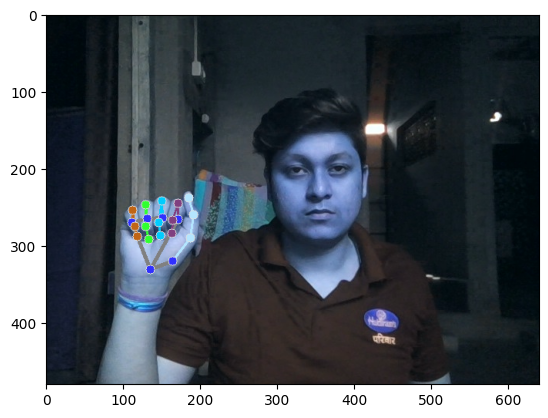

In [5]:
img = cv2.imread('A1.jpg')
plt.imshow(img)
results, image = mediapipe_detection(img, mp_hands)
if results.multi_hand_landmarks:
    for landmark in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(image, landmark, mp.solutions.hands.HAND_CONNECTIONS,
                                mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                                mp.solutions.drawing_styles.get_default_hand_connections_style())
plt.imshow(image)
# cv2.waitKey(27)
plt.show()

#### Demo for capturing the hand movements live using webcam

In [6]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    results, image = mediapipe_detection(frame, mp_hands)
    if results.multi_hand_landmarks:
        for landmark in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, landmark, mp.solutions.hands.HAND_CONNECTIONS,
                                    mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                                    mp.solutions.drawing_styles.get_default_hand_connections_style())

    
    cv2.imshow('Window', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [14]:
# again going to the folder where all collected images are saved.
%cd
%cd My_work/sign_images

C:\Users\HP
C:\Users\HP\My_work\sign_images


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Data Collection

In [8]:
from pathlib import Path

data = []
labels = []

cwd = Path.cwd()
folders = cwd.iterdir()

for folder in folders:
    files = folder.glob('*')
    for file in files:
        data_aux = []
        img = cv2.imread(str(file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        results = mp_hands.process(img_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x)
                    data_aux.append(y)
                    
            data.append(data_aux)
            labels.append(int(folder.name))
        
%cd
%cd My_work

C:\Users\HP
C:\Users\HP\My_work


In [9]:
len(data)

1828

### Model Building

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

data = np.asarray(data)
labels = np.asarray(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,shuffle=True, stratify=labels)

In [11]:
model = RandomForestClassifier(criterion='entropy',max_depth=55,min_samples_split=2,n_estimators=250)

model.fit(X_train, y_train)

y_predict = model.predict(X_test)

score = metrics.accuracy_score(y_predict, y_test)
print(f'{score}% of samples were classified correctly!')

0.8005464480874317% of samples were classified correctly!


In [12]:
i = 65
labelling = []
for char in range(1,27):
    labelling.append(chr(i))
    i = i+1
list(labelling)

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

### Live testing using webcame for the detection of sign alphabets.

In [15]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    data_aux = []

    x_ = []
    y_ = []
    ht = frame[0]
    frame  =cv2.flip(frame, 1)
    x1 = int(0.5 * frame.shape[1])
    # y1 = 10
    y1 = 4
    x2 = frame.shape[1] - 10
    y2 = int(0.5 * frame.shape[1])

    # print('shapes are : ',x1, y1, x2, y2)
    cv2.rectangle(frame, (x1+7, y1+30), (x2-1, y2+1), (85, 128, 255) ,2)
    
    img = frame[y1-1 : y2+1, x1+7 : x2-1]

    # print(img.shape)
    results, image = mediapipe_detection(img, mp_hands)
    if results.multi_hand_landmarks:
        for landmark in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img, landmark, mp.solutions.hands.HAND_CONNECTIONS,
                                    mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                                    mp.solutions.drawing_styles.get_default_hand_connections_style())

        for hand_landmarks in results.multi_hand_landmarks:
            for i in range(len(hand_landmarks.landmark)):
                x = hand_landmarks.landmark[i].x
                y = hand_landmarks.landmark[i].y
                data_aux.append(x)
                data_aux.append(y)
                x_.append(x)
                y_.append(y)

        prediction = model.predict([np.asarray(data_aux)])
        predicted_char = labelling[int(prediction[0])]
        cv2.putText(frame, predicted_char, (x1, y1+25), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (85, 128, 255),
                   2, cv2.LINE_AA)
        
        # cv2.imshow('Window', img)
    cv2.imshow('Window', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()